In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
sys.path.append('../')
from IPython.core.display import clear_output, display
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df, get_pd_line_graph, \
    apply_nodes_restrictions, apply_edge_restriction, construct_output_graph

from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical,DropFakes, DropSpinningTracks, DropShort
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from prepare import parse

csv_params = {
"sep": '\s+',
"nrows": 15000,
"encoding": 'utf-8',
"names": ['event',  'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0']
}

stations_constraints = {
    0: {'r': [-167., 167.], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]},
    1: {'r': [-167., 167.], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]},
    2: {'r': [-167., 167.], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]},
}


In [3]:
events = parse("../data/new_data/1.txt", csv_params=csv_params, events_quantity='0..300')
events = next(events)[0]
events_to_analyze = events[events.event < 300]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [36]:
from ariadne.tracknet_v2.model import TrackNETv2
import torch

gin.bind_parameter('TrackNETv2.input_features', 3)
gin.bind_parameter('TrackNETv2.conv_features', 32)
gin.bind_parameter('TrackNETv2.rnn_type', 'gru')
gin.bind_parameter('TrackNETv2.batch_first', True)

def weights_update(model, checkpoint):
    model_dict = model.state_dict()    
    pretrained_dict =  checkpoint['state_dict']
    real_dict = {}
    for (k,v) in model_dict.items():
        needed_key = None
        for pretr_key in pretrained_dict:
            if k in pretr_key:
                needed_key = pretr_key
                break
        assert needed_key is not None, "key %s not in pretrained_dict %r!" % (k, pretrained_dict.keys())
        real_dict[k] = pretrained_dict[needed_key]

    model.load_state_dict(real_dict)
    model.eval()
    return model

model = weights_update(model=TrackNETv2(), checkpoint=torch.load('../lightning_logs/epoch=270.ckpt'))


In [37]:
from ariadne.tracknet_v2.dataset import TrackNetV2ExplicitDataset
from ariadne.tracknet_v2.data_loader import TrackNetV2DataLoader

gin.bind_parameter('TrackNetV2ExplicitDataset.input_dir', '../output/cgem_t_plain_explicit_test')
gin.bind_parameter('TrackNetV2ExplicitDataset.input_file', 'tracknet_test_all_explicit.npz')
data_loader = TrackNetV2DataLoader(
    batch_size=500,
    dataset=TrackNetV2ExplicitDataset,
    valid_size=1.0
).get_val_dataloader()

In [38]:
import numpy as np
all_last_station_coordinates = np.load('../output/cgem_t_plain_explicit_test/tracknet_test_all_explicit_all_last_station.npz')
last_station_hits = all_last_station_coordinates['hits'][:, 1:]
last_station_hits_torch = torch.from_numpy(last_station_hits)

In [39]:
last_station_hits_torch.size()

torch.Size([4008, 2])

In [23]:
for batch in data_loader:
    print(batch)
    handle_batch(batch['x'], batch['y'], batch['is_real_track'], last_station_hits_torch)
    break

{'x': {'inputs': tensor([[[ 0.4884,  0.9697,  0.2359],
         [ 0.7548, -0.3501,  0.0408]],

        [[ 0.4884, -0.3879,  0.3106],
         [ 0.7548,  0.4520, -0.1058]]], dtype=torch.float64), 'input_lengths': tensor([2, 2])}, 'y': tensor([[-0.9708, -0.8363],
        [ 0.7650, -0.4842]], dtype=torch.float64), 'index': tensor([10212, 10323]), 'moment': tensor([[-0.0422, -0.1431, -0.3020],
        [ 0.2159, -0.2936, -0.4709]], dtype=torch.float64), 'is_real_track': tensor([0, 0])}
in model tensor([[[ 0.4884,  0.9697,  0.2359],
         [ 0.7548, -0.3501,  0.0408]],

        [[ 0.4884, -0.3879,  0.3106],
         [ 0.7548,  0.4520, -0.1058]]], dtype=torch.float64)
in model we feed tensor([[[ 0.4884,  0.7548],
         [ 0.9697, -0.3501],
         [ 0.2359,  0.0408]],

        [[ 0.4884,  0.7548],
         [-0.3879,  0.4520],
         [ 0.3106, -0.1058]]])
after all rnn stuff tensor([[[-2.7566e-02,  9.4343e-02, -3.1297e-02,  2.4001e-01,  1.2012e-01,
          -4.9626e-02, -3.8934e-01, -4

RuntimeError: X1 and X2 must have the same number of columns. X1: 4 X2: 2

In [ ]:
all_tracks_df = pd.DataFrame(columns=['event', 'track', 'hit_0_id', 'hit_1_id', 'hit_2_id', 'px', 'py', 'pz', 'pred'])
reco_df = all_tracks_df.copy()

In [6]:
from copy import copy

In [40]:
from ariadne.tracknet_v2.metrics import point_in_ellipse
def find_nearest_hit(ellipses,hits):
    centers = ellipses[:,:2]
    dists = torch.cdist(hits.float(), centers.float())
    min_argument = torch.argmin(dists, dim=0)
    minimal = hits[torch.argmin(dists, dim=0)]
    is_in_ellipse = point_in_ellipse(ellipses, minimal)
    return minimal, is_in_ellipse

def handle_batch(batch_input, batch_target, batch_real_flag, all_last_y):   
    with torch.no_grad():
        test_pred = model(inputs=batch_input['inputs'], input_lengths=batch_input['input_lengths'])
        num_real_tracks = batch_real_flag.sum()
        nearest_points, is_point_in_ellipse = find_nearest_hit(test_pred, all_last_y)
        is_prediction_true = (batch_target == nearest_points)
        is_prediction_true = is_prediction_true.sum(axis=1) / 2
        found_points = nearest_points[(is_point_in_ellipse) & (batch_real_flag == 1)]
        found_nothing = nearest_points[(~is_point_in_ellipse) & (batch_real_flag == 1)]
        num_points_for_real_tracks = len(found_points)
        num_fales_for_real_tracks = len(found_nothing)
        is_relevant_prediction_true = is_prediction_true[(batch_real_flag == 1) & (is_point_in_ellipse)]
        print(is_relevant_prediction_true)
        if num_real_tracks > 0:
            batch_recall = is_relevant_prediction_true.sum() / float(num_real_tracks)
            batch_precision = is_relevant_prediction_true.sum() / float(num_points_for_real_tracks)
            batch_fale_rate = num_fales_for_real_tracks / float(num_real_tracks)
            print(batch_recall, batch_precision, batch_fale_rate )
            return batch_recall, batch_precision, batch_fale_rate
        else:
            return -1,-1,-1
            
def handle_batch_to_df(orig_batch, all_last_y):   
    with torch.no_grad():
        temp_dict = {}
        batch = copy(orig_batch)
        temp_df = pd.DataFrame(columns=['found_nothing', 'found_right_point','is_real_track', 'px','py','pz','p'])
        batch_input = batch['x']
        batch_real_flag = batch['is_real_track']
        batch_target = batch['y']
        test_pred = model(inputs=batch_input['inputs'], input_lengths=batch_input['input_lengths'])
        num_real_tracks = batch_real_flag.sum()
        nearest_points, is_point_in_ellipse = find_nearest_hit(test_pred, all_last_y)
        is_prediction_true = (batch_target == nearest_points)
        is_prediction_true = is_prediction_true.sum(axis=1) / 2
        found_points = (is_point_in_ellipse) & (batch_real_flag == 1)
        found_nothing = (~is_point_in_ellipse) & (batch_real_flag == 1)
        found_right_points = found_points & is_prediction_true.bool()
        num_points_for_real_tracks = found_points.sum()
        num_fales_for_real_tracks = found_nothing.sum()
        temp_dict['px'] = batch['moment'][:, 0].detach().cpu().numpy()
        temp_dict['py'] = batch['moment'][:, 1].detach().cpu().numpy()
        temp_dict['pz'] = batch['moment'][:, 2].detach().cpu().numpy()
        temp_dict['p'] = torch.norm(batch['moment'], dim=1).detach().cpu().numpy()
        temp_dict['found_nothing'] = found_nothing.detach().cpu().numpy()
        temp_dict['found_right_point'] = found_right_points.detach().cpu().numpy()
        temp_dict['is_real_track'] = batch_real_flag.detach().cpu().numpy()
        temp_df = pd.DataFrame(temp_dict)
        return temp_df
        

In [41]:
recalls = []
precisions = []
fale_rates = []
result_df = pd.DataFrame(columns=['found_nothing', 'found_right_point','is_real_track', 'px','py','pz','p'])
for batch in data_loader:
    df = handle_batch_to_df(batch, last_station_hits_torch)
    #print(df.head())
    result_df = pd.concat([result_df,df], axis=0)
    #print(result_df.shape)

In [42]:
real_tracks = copy(result_df.loc[result_df['is_real_track']==1, ])

In [43]:
recall = real_tracks['found_right_point'].sum() / float(len(real_tracks))
precision = real_tracks['found_right_point'].sum() / float(len(real_tracks) - real_tracks['found_nothing'].sum())
fale_rate = (len(real_tracks['found_right_point']) - real_tracks['found_right_point'].sum()) / float(len(real_tracks))

In [44]:
print('Test set results:')
#print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % precision)
print('Recall:    %.4f' % recall)
print('Fale rate:    %.4f' % fale_rate)

Test set results:
Precision: 0.0003
Recall:    0.0002
Fale rate:    0.9998


In [15]:
result_df.loc[result_df['is_real_track']==1,].found_right_point.sum()

3110

In [48]:
# shortcut
from numpy import linalg as LA

result_df['pt'] = LA.norm(result_df[['px','py']].values, axis=1)
result_df['cos_t'] = (result_df[['pz']].values/ LA.norm(result_df[['px','py','pz']].values, axis=1, keepdims=True))
result_df['a_phi'] = np.arctan2(result_df[['px']].values, result_df[['py']].values)

In [49]:
def get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col):
    spac = np.linspace(start, end, num=num)
    
    arr = []
    
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] > beg) &(all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] > beg) &(found_hits[col] < end)]
        if elems_real.empty:
            arr.append(np.NaN)
            continue
        arr.append(len(elems_pred) / len(elems_real))
    
    return arr, spac[:-1]

In [50]:
from scipy.interpolate import make_interp_spline, BSpline


def draw_for_col(tracks_real, tracks_pred_true,
                 col, col_pretty, total_events, n_ticks=150, save_disk=True):
    
    start = tracks_real[tracks_real[col] > -np.inf][col].min()
    end = tracks_real[tracks_real[col] < np.inf][col].max()

    initial, spac = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, n_ticks, col)
    
    # mean line
    # find number of ticks until no nans present
    second = np.array([np.nan])
    count_start = n_ticks // 5
    while np.isnan(second).any():
        second, spac2 = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, count_start, col)
        count_start = count_start - count_start // 2

    xnew = np.linspace(spac2.min(), spac2.max(), count_start) 
    
    spl = make_interp_spline(spac2, second, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    
    
    maxX = end
    plt.figure(figsize=(8,7))
    
    plt.subplot(111)
    plt.ylabel('Track efficiency', fontsize=12)
    plt.xlabel(col_pretty, fontsize=12)
    #plt.axis([0, maxX, 0, 1.005])
    plt.plot(spac, initial, alpha=0.8, lw=0.8)
    plt.title('TrackNetV2 track efficiency vs impulse (%d events)' % total_events, fontsize=14)
    plt.plot(xnew, power_smooth, ls='--', label='mean', lw=2.5)
    plt.xticks(np.linspace(start, maxX, 8))
    plt.yticks(np.linspace(0, 1, 9))
    plt.legend(loc=0)
    plt.grid()
    plt.tight_layout()
    plt.rcParams['savefig.facecolor']='white'
    os.makedirs('../output', exist_ok=True)
    plt.savefig('../output/img_track_eff_%s_ev%r_t%d.png'%(col, total_events, n_ticks), dpi=300)
    plt.show()

#from scipy.interpolate import make_interp_spline, BSpline
#second, spac2 = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, 25, 'pt')
#
#xnew = np.linspace(spac2.min(), spac2.max(), 30) 
#
#spl = make_interp_spline(spac2, second, k=3)  # type: BSpline
#power_smooth = spl(xnew)

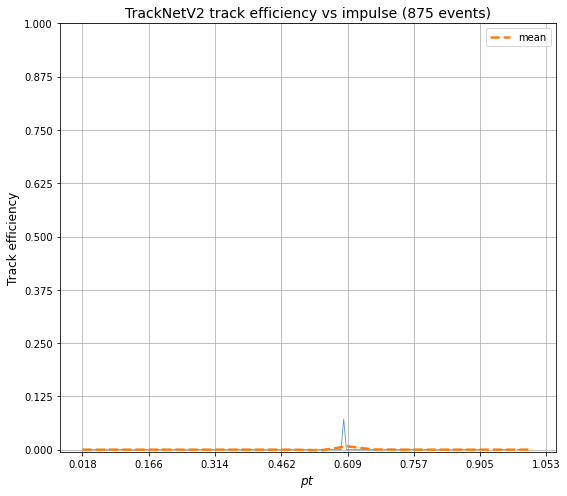

In [51]:
true_tracks_result_df = result_df[result_df.is_real_track == 1]
tracks_pred_true = true_tracks_result_df[true_tracks_result_df.found_right_point]
tracks_real = true_tracks_result_df[(true_tracks_result_df.found_right_point == False)  | (true_tracks_result_df.found_nothing==True)]
draw_for_col(true_tracks_result_df, tracks_pred_true, 'pt', '$pt$', 875, 175)

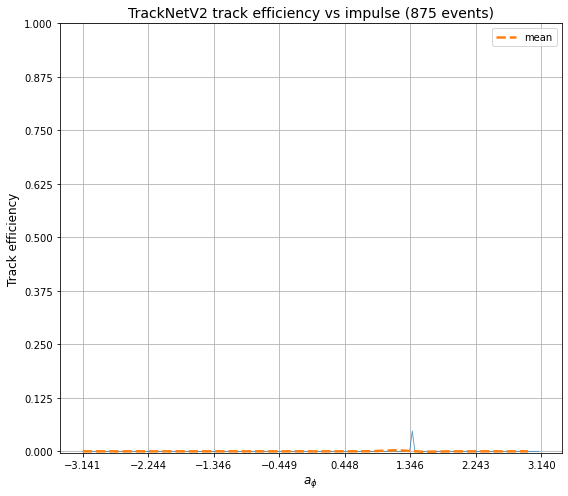

In [52]:
draw_for_col(true_tracks_result_df, tracks_pred_true, 'a_phi', '$a_\phi$',875,175)

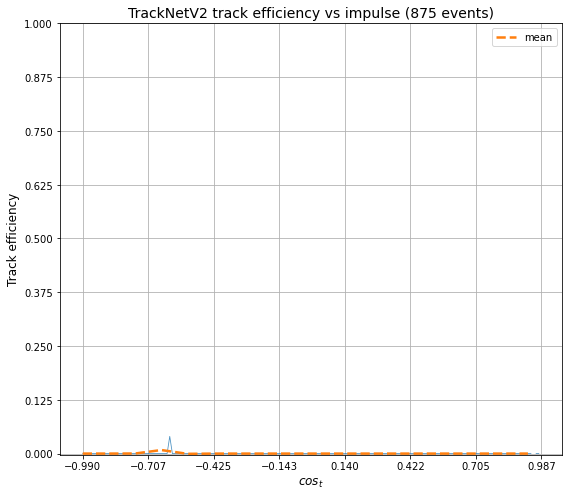

In [53]:
draw_for_col(true_tracks_result_df, tracks_pred_true, 'cos_t', '$cos_t$',875,175)